#### From https://cvxopt.org/examples/tutorial/lp.html#solving-a-linear-program
# Solving a linear program

In [25]:
from cvxopt import matrix, solvers

In [29]:
# A x <= b
A = matrix([ [-1.0, -1.0, 0.0, 1.0], [1.0, -1.0, -1.0, -2.0] ])
b = matrix([ 1.0, -2.0, 0.0, 4.0 ])

c = matrix([ 2.0, 1.0 ]) # c.T @ x

In [31]:
sol=solvers.lp(c,A,b)

In [43]:
print(sol['x'])

[ 5.00e-01]
[ 1.50e+00]



In [38]:
print([x for x in dir(sol['x']) if not x.startswith('_')])

['H', 'T', 'ctrans', 'fromfile', 'imag', 'real', 'size', 'tofile', 'trans', 'typecode']


In [42]:
sol['x']

<2x1 matrix, tc='d'>

## Solving a quadratic program

In [44]:
from cvxopt import matrix, solvers
Q = 2*matrix([ [2, .5], [.5, 1] ])
p = matrix([1.0, 1.0])
G = matrix([[-1.0,0.0],[0.0,-1.0]])
h = matrix([0.0,0.0])
A = matrix([1.0, 1.0], (1,2))
b = matrix(1.0)
sol=solvers.qp(Q, p, G, h, A, b)

In [47]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <1x1 matrix, tc='d'>,
 's': <2x1 matrix, tc='d'>,
 'z': <2x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 1.052702838051502e-07,
 'relative gap': 5.614415451491214e-08,
 'primal objective': 1.875000000000018,
 'dual objective': 1.8749998947297342,
 'primal infeasibility': 1.1102230246251565e-16,
 'dual infeasibility': 5.3147592893303475e-08,
 'primal slack': 0.2500000952702475,
 'dual slack': 1.0000000000000038e-08,
 'iterations': 4}

In [46]:
print(sol['x'])

[ 2.50e-01]
[ 7.50e-01]



## From https://cvxopt.org/examples/book/rls.html
## Figure 4.11, page 185.
# Regularized least-squares.

In [4]:

from pickle import load
from cvxopt import blas, lapack, matrix, solvers
solvers.options['show_progress'] = 0

In [14]:
data = load(open("rls.bin",'rb'))
A, b = data['A'], data['b'] # A = 100x10 (cvxopt.base.)matrix, b = 100x1 vector
m, n = A.size
print(m, n)

100 10


In [15]:
# LS solution
xls = +b
lapack.gels(+A, xls)
xls = xls[:n]

In [19]:
lapack.gels?

Docstring:
Solves least-squares and least-norm problems with full rank
matrices.

gels(A, B, trans='N', m=A.size[0], n=A.size[1], nrhs=B.size[1],
     ldA=max(1,A.size[0]), ldB=max(1,B.size[0]), offsetA=0,
     offsetB=0)

PURPOSE
1. If trans is 'N' and A and B are real/complex:
- if m >= n: minimizes ||A*X - B||_F.
- if m < n: minimizes ||X||_F subject to A*X = B.

2. If trans is 'N' or 'C' and A and B are real:
- if m >= n: minimizes ||X||_F subject to A^T*X = B.
- if m < n: minimizes ||X||_F subject to A^T*X = B.

3. If trans is 'C' and A and B are complex:
- if m >= n: minimizes ||X||_F subject to A^H*X = B.
- if m < n: minimizes ||X||_F subject to A^H*X = B.

A is an m by n matrix.  B has nrhs columns.  On exit, B is
replaced with the solution, and A is replaced with the details
of its QR or LQ factorization.

Note that gels does not check whether A has full rank.

ARGUMENTS
A         'd' or 'z' matrix

B         'd' or 'z' matrix.  Must have the same type as A.

trans     'N', 'T

In [23]:
# We compute the optimal values of
#
#     minimize/maximize  || A*x - b ||_2^2
#     subject to         x'*x = alpha
#
# via the duals.
#
# Lower bound:
#
#     maximize    -t - u*alpha
#     subject to  [u*I, 0; 0, t] + [A, b]'*[A, b] >= 0
#
# Upper bound:
#
#     minimize    t + u*alpha
#     subject to  [u*I, 0; 0, t] - [A, b]'*[A, b] >= 0.
#
# Two variables (t, u).

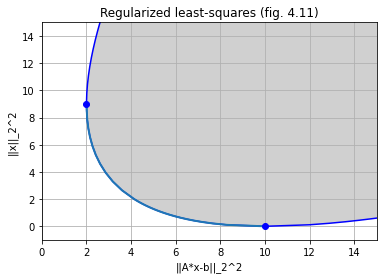

In [24]:
G = matrix(0.0, ((n+1)**2, 2))
G[-1, 0] = -1.0    # coefficient of t
G[: (n+1)**2-1 : n+2, 1] = -1.0    # coefficient of u
h = matrix( [ [ A.T * A,  b.T * A ], [ A.T * b, b.T * b ] ] )
c = matrix(1.0, (2,1))

nopts = 40
alpha1 = [2.0/(nopts//2-1) * alpha for alpha in range(nopts//2) ] + \
    [ 2.0 + (15.0 - 2.0)/(nopts//2) * alpha for alpha in
        range(1,nopts//2+1) ]
lbnds = [ blas.nrm2(b)**2 ]
for alpha in alpha1[1:]:
    c[1:] = alpha
    lbnds += [ -blas.dot(c, solvers.sdp(c, Gs=[G], hs=[h])['x']) ]

nopts = 10
alpha2 = [ 1.0/(nopts-1) * alpha for alpha in range(nopts) ]
ubnds = [ blas.nrm2(b)**2 ]
for alpha in alpha2[1:]:
    c[1:] = alpha
    ubnds += [ blas.dot(c, solvers.sdp(c, Gs=[G], hs=[-h])['x']) ]

try: import pylab
except ImportError: pass
else:
    pylab.figure(1, facecolor='w')
    pylab.plot(lbnds, alpha1, 'b-', ubnds, alpha2, 'b-')
    kmax = max([ k for k in range(len(alpha1)) if alpha1[k] <
        blas.nrm2(xls)**2 ])
    pylab.plot( [ blas.nrm2(b)**2 ] + lbnds[:kmax] +
        [ blas.nrm2(A*xls-b)**2 ], [0.0] + alpha1[:kmax] +
        [ blas.nrm2(xls)**2 ], '-', linewidth=2)
    pylab.plot([ blas.nrm2(b)**2, blas.nrm2(A*xls-b)**2 ],
        [0.0, blas.nrm2(xls)**2], 'bo')
    pylab.fill(lbnds[-1::-1] + ubnds + [ubnds[-1]],
        alpha1[-1::-1] + alpha2+ [alpha1[-1]], facecolor = '#D0D0D0')
    pylab.axis([0, 15, -1.0, 15])
    pylab.xlabel('||A*x-b||_2^2')
    pylab.ylabel('||x||_2^2')
    pylab.grid()
    pylab.title('Regularized least-squares (fig. 4.11)')
    pylab.show()